In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [11]:
sm.version.full_version

'0.9.0'

In [12]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [13]:
passengers = pd.Series(df['#Passengers'],dtype='float')
passengers.index = pd.to_datetime(df['Month'])
passengers.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

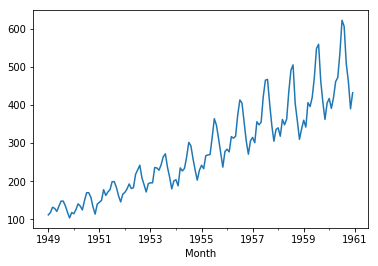

In [14]:
passengers.plot()

In [15]:
sm.tsa.seasonal_decompose(passengers)

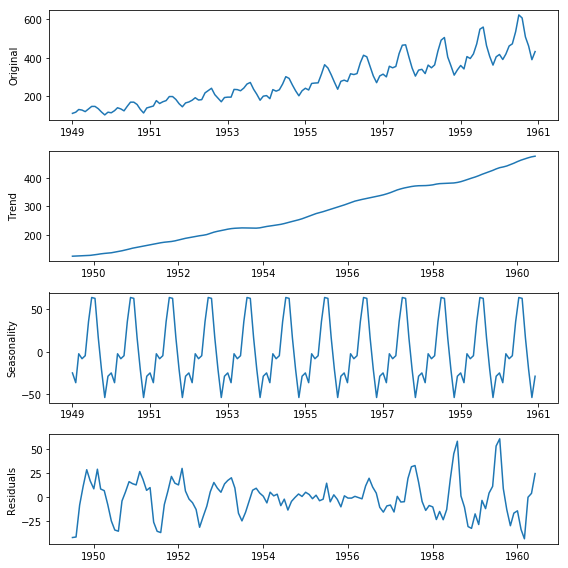

In [16]:
res = sm.tsa.seasonal_decompose(passengers)

original = passengers
trend = res.trend
seasonal = res.seasonal
residual = res.resid

plt.figure(figsize=(8,8))

#plt.subplot(行数, 列数, 何番目のプロットか)
plt.subplot(411)
plt.plot(original)
plt.ylabel('Original')

plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')

plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout()

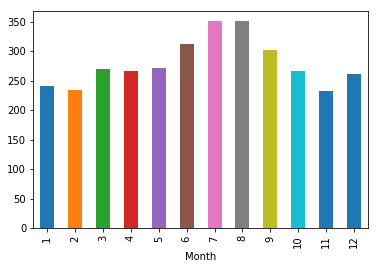

In [17]:
passengers_month_mean = passengers.groupby(passengers.index.month).mean()
passengers_month_mean.plot(kind='bar')

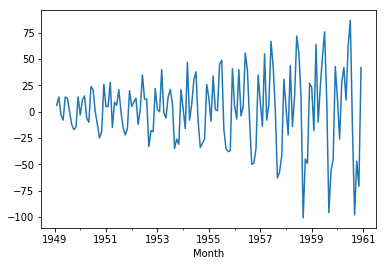

In [18]:
passengers_diff = passengers - passengers.shift()
passengers_diff = passengers_diff.dropna()
passengers_diff.plot()

In [19]:
import warnings
warnings.filterwarnings('ignore')

res_selection = sm.tsa.arma_order_select_ic(passengers_diff,ic='aic',trend='nc')
res_selection

{'aic':              0            1            2
 0          NaN  1397.257791  1397.093436
 1  1401.852641  1412.615224  1385.496795
 2  1396.587654  1378.338024  1353.175678
 3  1395.021214  1379.614000  1351.138642
 4  1388.216680  1379.616584  1373.560615, 'aic_min_order': (3, 2)}

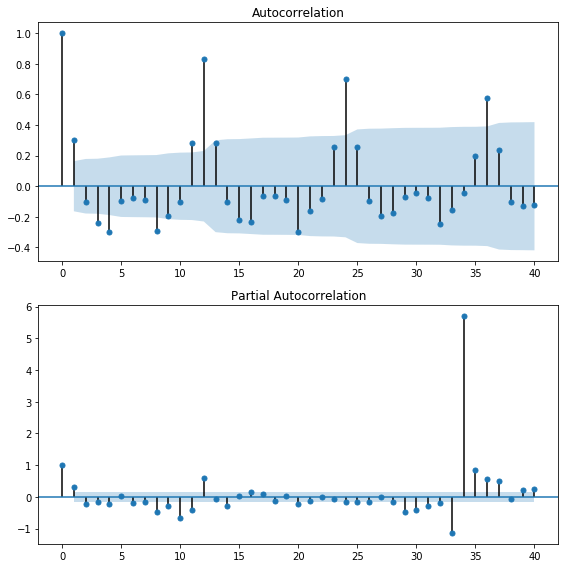

In [20]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(passengers_diff,lags=40,ax=ax1)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(passengers_diff,lags=40,ax=ax2)

plt.tight_layout()

In [21]:
sarimax = sm.tsa.SARIMAX(passengers,
                        order=(3,1,2),
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity =False,
                        enforce_invertibility=False
                        ).fit()
sarimax_resid = sarimax.resid

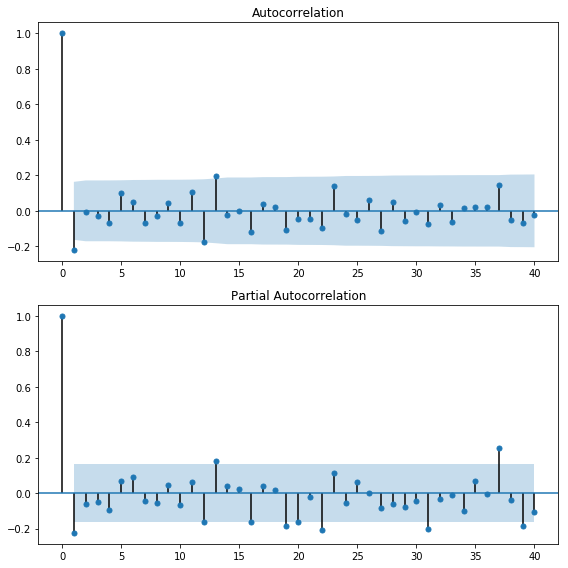

In [22]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid,lags=40,ax=ax1)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid,lags=40,ax=ax2)

plt.tight_layout()

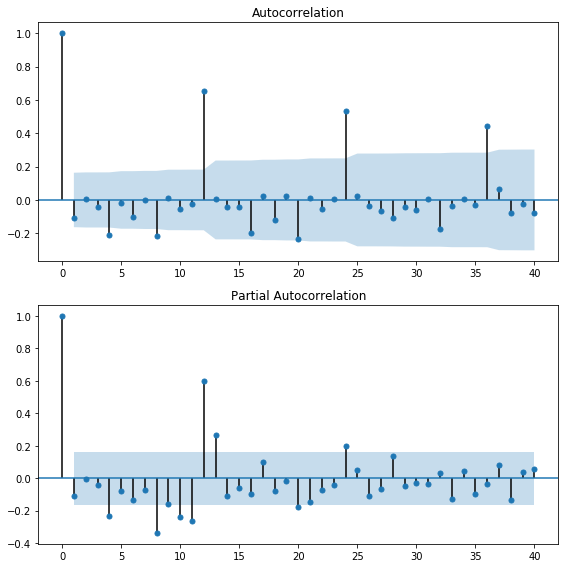

In [23]:
# SRIMAモデル（試しに）季節調整なし
sarimax_noseasonal = sm.tsa.SARIMAX(passengers, 
                        order=(3, 1, 2),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_noseasonal_resid = sarimax_noseasonal.resid # 残差成分

fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_noseasonal_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_noseasonal_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [24]:
print(sarimax.aic)
print(sarimax_noseasonal.aic)

914.0438874014557
1352.004405042127


In [25]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(3, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -449.022
Date:                            Fri, 12 Oct 2018   AIC                            914.044
Time:                                    09:04:40   BIC                            936.073
Sample:                                01-01-1949   HQIC                           922.986
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0179      0.783      1.301      0.193      -0.516       2.552
ar.L2          0.0165      0.525      0.031      0.975      -1.013       1.046
ar.L3         -0.1802      0.144     -1.250      0.211      -0.463       0.102
ma.L1         -1.4080      0.792     -1.778      0.075      -2.960       0.144
ma.L2          0.4200      0.776      0.541      0.588      -1.101       1.941
ar.S.L12      -0.5400      0.340     -1.588      0.112      -1.206       0.126
ma.S.L12       0.4129      0.405      1.019      0.308      -0.381       1.207
sigma2       131.2928     17.806      7.374      0.000      96.394     166.192
===================================================================================
Ljung-Box (Q):                       49.54   Jarque-Bera (JB):                13.36
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

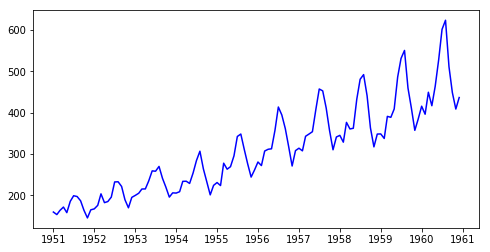

In [26]:
sarimax_pred = sarimax.predict('1951-01','1960-12')
plt.figure(figsize=(8,4))
plt.plot(sarimax_pred,c="b")

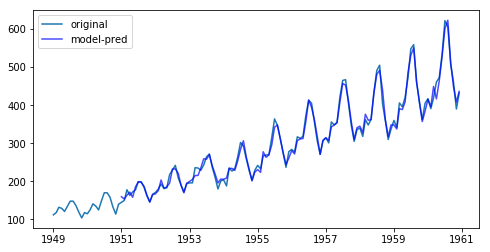

In [27]:
sarimax_pred = sarimax.predict('1951-01','1960-12')

plt.figure(figsize=(8,4))

plt.plot(passengers,label="original")
plt.plot(sarimax_pred,c="b",label="model-pred",alpha=0.7)
plt.legend(loc='best')

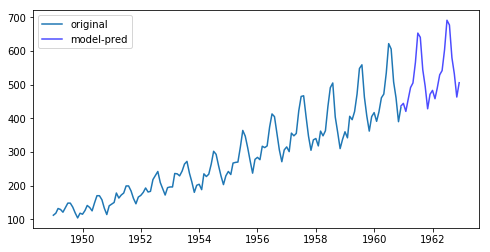

In [28]:
sarimax_pred = sarimax.predict('1960-12','1962-12')

plt.figure(figsize=(8,4))

plt.plot(passengers,label="original")
plt.plot(sarimax_pred,c="b",label="model-pred",alpha=0.7)
plt.legend(loc='best')

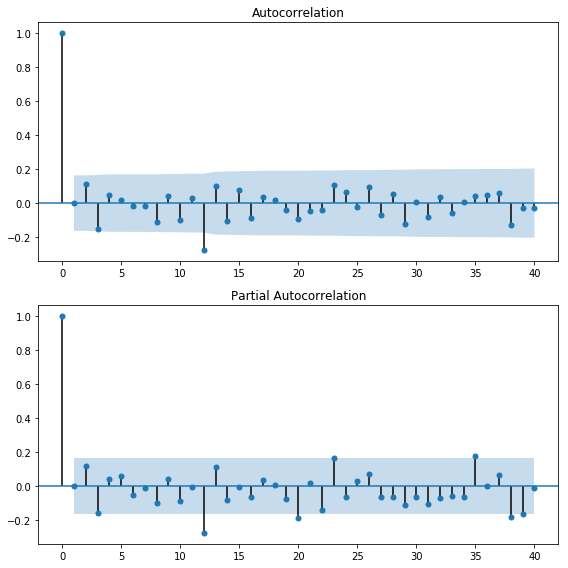

In [30]:
# SRIMAモデル（ちょっとだけパラメータ最適化・総当たりaicベストを適用）
sarimax_optimization = sm.tsa.SARIMAX(passengers, 
                        order=(3, 1, 3),
                        seasonal_order=(0, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

sarimax_optimization_resid = sarimax_optimization.resid # 残差成分

fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_optimization_resid, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_optimization_resid, lags=40, ax=ax2) #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

In [31]:
passengers_train = passengers['1949-01':'1958-12']

print(passengers_train.head())
print(passengers_train.tail())

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64
Month
1958-08-01    505.0
1958-09-01    404.0
1958-10-01    359.0
1958-11-01    310.0
1958-12-01    337.0
Name: #Passengers, dtype: float64


In [32]:
passengers_test = passengers['1958-01':'1960-12']
print(passengers_test.head())
print(passengers_test.tail())

Month
1958-01-01    340.0
1958-02-01    318.0
1958-03-01    362.0
1958-04-01    348.0
1958-05-01    363.0
Name: #Passengers, dtype: float64
Month
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: #Passengers, dtype: float64


In [33]:
sarimax_train = sm.tsa.SARIMAX(passengers_train,
                              order=(3,1,3),
                              seasonal_order=(0,1,1,12),
                              enforce_stationarity=False,
                              enforce_invertibility=False
                              ).fit()
sarimax_train_pred = sarimax_train.predict('1958-12','1960-12')

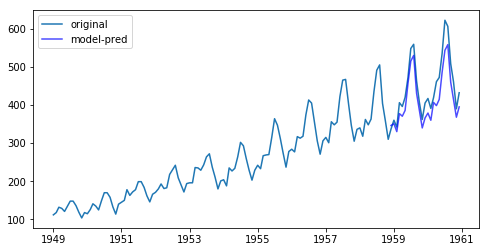

In [34]:
plt.figure(figsize=(8,4))

plt.plot(passengers,label='original')
plt.plot(sarimax_train_pred,c='b',label='model-pred',alpha=0.7)
plt.legend(loc='best')

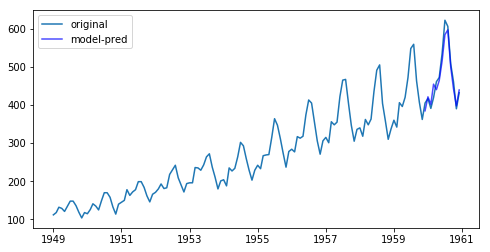

In [39]:
passengers_train2 = passengers['1949-01':'1959-12']

passengers_test2 = passengers['1960-01':'1960-12']

sarimax_train = sm.tsa.SARIMAX(passengers_train2,
                              order=(3,1,3),
                              seasonal_order=(0,1,1,12),
                              enforce_stationarity=False,
                              enforce_invertibility=False
                              ).fit()
sarimax_train2_pred=sarimax_train.predict('1959-12','1960-12')

plt.figure(figsize=(8,4))

plt.plot(passengers,label='original')
plt.plot(sarimax_train2_pred,c='b',label='model-pred',alpha=0.7)
plt.legend(loc='best')

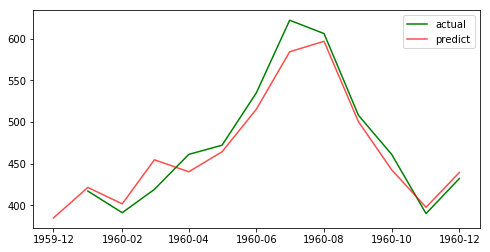

In [59]:
plt.figure(figsize=(8,4))

plt.plot(passengers_test2,c='g',label='actual')
plt.plot(sarimax_train2_pred,c='r',label='predict',alpha=0.7)

plt.legend(loc='best')

In [42]:
predict_dy = sarimax_train.get_prediction(start='1959-12',end='1960-12')
type(predict_dy)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [44]:
predict_dy_ci = predict_dy.conf_int(alpha=0.05)
type(predict_dy_ci)

pandas.core.frame.DataFrame

In [45]:
predict_dy_ci

,lower #Passengers,upper #Passengers
1959-12-01,365.171718,404.342314
1960-01-01,401.752796,440.917256
1960-02-01,376.600154,426.602969
1960-03-01,424.879292,484.178256
1960-04-01,408.392822,471.906779
1960-05-01,431.429890,496.736232
1960-06-01,481.438630,549.045850
1960-07-01,549.544365,618.782568
1960-08-01,561.846364,631.616038
1960-09-01,465.090516,535.525167


In [46]:
predict_dy.predicted_mean

1959-12-01    384.757016
1960-01-01    421.335026
1960-02-01    401.601562
1960-03-01    454.528774
1960-04-01    440.149800
1960-05-01    464.083061
1960-06-01    515.242240
1960-07-01    584.163467
1960-08-01    596.731201
1960-09-01    500.307841
1960-10-01    442.505979
1960-11-01    397.514314
1960-12-01    439.229727
Freq: MS, dtype: float64

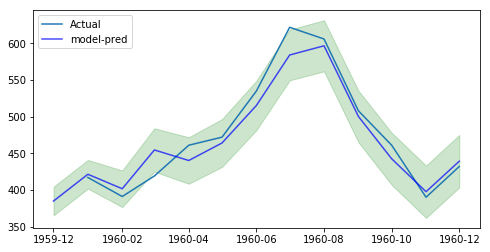

In [48]:
plt.figure(figsize=(8,4))

plt.plot(passengers_test2,label='Actual')
plt.plot(predict_dy.predicted_mean,c='b',label='model-pred',alpha=0.7)

plt.fill_between(predict_dy_ci.index,predict_dy_ci.iloc[:,0],predict_dy_ci.iloc[:,1],color='g',alpha=0.2)
plt.legend(loc='upper left')

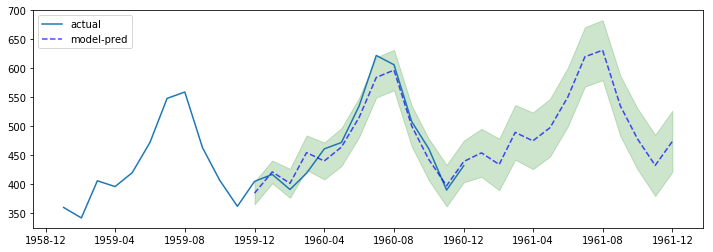

In [51]:
predict2_dy = sarimax_train.get_prediction(start='1959-12',end='1961-12')

predict2_dy_ci = predict2_dy.conf_int()

plt.figure(figsize=(12,4))
plt.plot(passengers['1959-01':],label='actual')
plt.plot(predict2_dy.predicted_mean,c='b',linestyle='--',label='model-pred',alpha=0.7)

plt.fill_between(predict2_dy_ci.index,predict2_dy_ci.iloc[:,0],predict2_dy_ci.iloc[:,1],color='g',alpha=0.2)
plt.legend(loc='upper left')

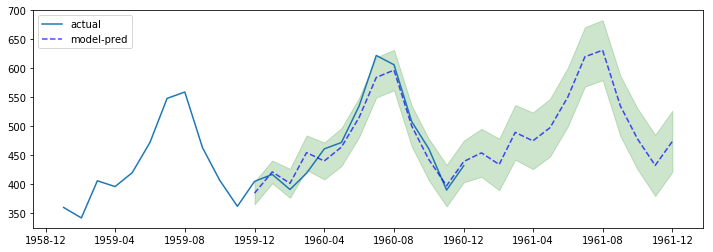

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import statsmodels.api as sm

df = pd.read_csv('AirPassengers.csv')

passengers = pd.Series(df['#Passengers'],dtype='float')
passengers.index = pd.to_datetime(df['Month'])

passengers_train2 = passengers['1949-01':'1959-12']
passengers_test2 = passengers['1960-01':'1960-12']

sarimax_train = sm.tsa.SARIMAX(passengers_train2,
                              order=(3,1,3),
                              seasonal_order=(0,1,1,12),
                              enforce_stationarity=False,
                              enforce_invertibility=False
                              ).fit()

predict2_dy = sarimax_train.get_prediction(start='1959-12',end='1961-12')
predict2_dy_ci = predict2_dy.conf_int()

plt.figure(figsize=(12,4))
plt.plot(passengers['1959-01':],label='actual')
plt.plot(predict2_dy.predicted_mean,c='b',linestyle='--',label='model-pred',alpha=0.7)

plt.fill_between(predict2_dy_ci.index,predict2_dy_ci.iloc[:,0],predict2_dy_ci.iloc[:,1],color='g',alpha=0.2)
plt.legend(loc='upper left')